In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle
%matplotlib inline


In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

False

## Utility functions

In [3]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

class FeaturesDataset(Dataset):

    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst

    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])

    def __len__(self):
        return len(self.labellst)

def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)

        running_loss += F.cross_entropy(output,target,size_average=False).data[0]
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [4]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [5]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# For Dogs & Cats dataset
train_dset = ImageFolder('/content/drive/My Drive/Materi Kuliah/Deep Learning/session 10/Chapter08/train/',transform=data_transform)
val_dset = ImageFolder('/content/drive/My Drive/Materi Kuliah/Deep Learning/session 10/Chapter08/dogsandcats/valid/',transform=data_transform)
classes=2

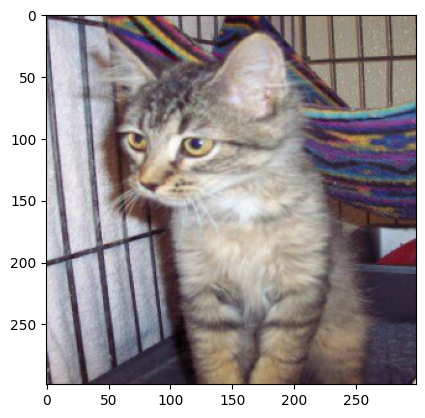

In [ ]:
imshow(train_dset[11][0])

## Creating data loader for training and validation datasets

In [ ]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Creating ResNet 34 model

In [ ]:
my_resnet = resnet34(pretrained=True)

if is_cuda:
    my_resnet = my_resnet.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 132MB/s]


In [ ]:
m = nn.Sequential(*list(my_resnet.children())[:-1])

## Extracting Convolutional features

In [ ]:
#For training data

# Stores the labels of the train data
trn_labels = []

# Stores the pre convoluted features of the train data
trn_features = []

#Iterate through the train data and store the calculated features and the labels
for d,la in train_loader:
    o = m(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    trn_labels.extend(la)
    trn_features.extend(o.cpu().data)

#For validation data

#Iterate through the validation data and store the calculated features and the labels
val_labels = []
val_features = []
for d,la in val_loader:
    o = m(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    val_labels.extend(la)
    val_features.extend(o.cpu().data)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Creating train and validation feature dataset

In [ ]:
#Creating dataset for train and validation
trn_feat_dset = FeaturesDataset(trn_features,trn_labels)
val_feat_dset = FeaturesDataset(val_features,val_labels)

#Creating data loader for train and validation
trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

NameError: name 'val_features' is not defined

## A Fully connected network

In [ ]:
class FullyConnectedModel(nn.Module):

    def __init__(self,in_size,out_size):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [ ]:
fc_in_size = 8192

In [ ]:
fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [ ]:
optimizer = optim.Adam(fc.parameters(),lr=0.0001)

## Train and validate the model

In [ ]:

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   0.5 and training accuracy is 17552/23000     76.31
validation loss is  0.39 and validation accuracy is 1709/2000     85.45
training loss is  0.36 and training accuracy is 19833/23000     86.23
validation loss is  0.32 and validation accuracy is 1762/2000      88.1
training loss is   0.3 and training accuracy is 20540/23000      89.3
validation loss is  0.27 and validation accuracy is 1819/2000     90.95
training loss is  0.25 and training accuracy is 21077/23000     91.64
validation loss is  0.24 and validation accuracy is 1849/2000     92.45
training loss is  0.23 and training accuracy is 21299/23000      92.6
validation loss is  0.24 and validation accuracy is 1834/2000      91.7
training loss is  0.21 and training accuracy is 21468/23000     93.34
validation loss is  0.22 and validation accuracy is 1832/2000      91.6
training loss is  0.19 and training accuracy is 21623/23000     94.01
validation loss is  0.21 and validation accuracy is 1847/2000     92.35
traini

In [ ]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.16 and training accuracy is 21909/23000     95.26
validation loss is  0.16 and validation accuracy is 1893/2000     94.65
training loss is  0.15 and training accuracy is 21961/23000     95.48
validation loss is  0.15 and validation accuracy is 1901/2000     95.05
training loss is  0.14 and training accuracy is 22006/23000     95.68
validation loss is  0.15 and validation accuracy is 1909/2000     95.45
training loss is  0.13 and training accuracy is 22051/23000     95.87
validation loss is  0.15 and validation accuracy is 1900/2000      95.0
training loss is  0.13 and training accuracy is 22095/23000     96.07
validation loss is  0.15 and validation accuracy is 1895/2000     94.75
training loss is  0.12 and training accuracy is 22164/23000     96.37
validation loss is  0.14 and validation accuracy is 1899/2000     94.95
training loss is  0.12 and training accuracy is 22181/23000     96.44
validation loss is  0.13 and validation accuracy is 1914/2000      95.7
traini

In [ ]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.11 and training accuracy is 22288/23000      96.9
validation loss is  0.12 and validation accuracy is 1923/2000     96.15
training loss is   0.1 and training accuracy is 22301/23000     96.96
validation loss is  0.11 and validation accuracy is 1925/2000     96.25
training loss is   0.1 and training accuracy is 22284/23000     96.89
validation loss is  0.11 and validation accuracy is 1928/2000      96.4
training loss is 0.095 and training accuracy is 22371/23000     97.27
validation loss is  0.11 and validation accuracy is 1927/2000     96.35
training loss is 0.094 and training accuracy is 22363/23000     97.23
validation loss is  0.11 and validation accuracy is 1925/2000     96.25
training loss is  0.09 and training accuracy is 22404/23000     97.41
validation loss is  0.11 and validation accuracy is 1923/2000     96.15
training loss is 0.089 and training accuracy is 22406/23000     97.42
validation loss is   0.1 and validation accuracy is 1926/2000      96.3
traini

In [ ]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.082 and training accuracy is 22473/23000     97.71
validation loss is   0.1 and validation accuracy is 1934/2000      96.7
training loss is  0.08 and training accuracy is 22456/23000     97.63
validation loss is  0.12 and validation accuracy is 1917/2000     95.85
training loss is 0.077 and training accuracy is 22507/23000     97.86
validation loss is   0.1 and validation accuracy is 1930/2000      96.5
training loss is 0.075 and training accuracy is 22518/23000      97.9
validation loss is 0.096 and validation accuracy is 1938/2000      96.9
training loss is 0.073 and training accuracy is 22539/23000      98.0
validation loss is   0.1 and validation accuracy is 1936/2000      96.8
training loss is 0.073 and training accuracy is 22542/23000     98.01
validation loss is 0.089 and validation accuracy is 1942/2000      97.1
training loss is 0.071 and training accuracy is 22545/23000     98.02
validation loss is  0.09 and validation accuracy is 1941/2000     97.05
traini